# Steady State Heat Equation

Here we use [MethodOfLines.jl](http://methodoflines.sciml.ai/dev/) to sumbolically define the PDE system in finite difference method (FDM).


$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0
$$

In [1]:
using ModelingToolkit
using MethodOfLines
using DomainSets
using NonlinearSolve
using Plots

In [2]:
@parameters x y
@variables u(..)

Dxx = Differential(x)^2
Dyy = Differential(y)^2

# PDE equation
eq = Dxx(u(x, y)) + Dyy(u(x, y)) ~ 0

# Boundary conditions
bcs = [u(0, y) ~ x * y,
       u(1, y) ~ x * y,
       u(x, 0) ~ x * y,
       u(x, 1) ~ x * y]

# Space and time domains
domains = [x ∈ Interval(0.0, 1.0),
           y ∈ Interval(0.0, 1.0)]

@named pdesys = PDESystem([eq], bcs, domains, [x, y], [u(x, y)])

PDESystem
Equations: Equation[Differential(x)(Differential(x)(u(x, y))) + Differential(y)(Differential(y)(u(x, y))) ~ 0]
Boundary Conditions: Equation[u(0, y) ~ x*y, u(1, y) ~ x*y, u(x, 0) ~ x*y, u(x, 1) ~ x*y]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0..1.0), Symbolics.VarDomainPairing(y, 0.0..1.0)]
Dependent Variables: Num[u(x, y)]
Independent Variables: Num[x, y]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [3]:
# Discretization of 2D sapce
N = 10
dx = 1 / N
dy = 1 / N

# Note that we pass in `nothing` for the time variable `t` here since we
# are creating a stationary problem without a dependence on time, only space.
discretization = MOLFiniteDifference([x => dx, y => dy], nothing, approx_order=2)

MOLFiniteDifference{MethodOfLines.CenterAlignedGrid}(Pair{Num, Float64}[x => 0.1, y => 0.1], nothing, 2, MethodOfLines.UpwindScheme(), MethodOfLines.CenterAlignedGrid(), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [4]:
prob = discretize(pdesys, discretization)

sol = NonlinearSolve.solve(prob, NewtonRaphson())

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = (::NonlinearSolve.DefaultLinSolve)(x::Vector{Float64}, A::Matrix{Float64}, b::Vector{Float64}, update_matrix::Bool; tol::Nothing, kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}) at utils.jl:124
└ @ NonlinearSolve /root/.julia/packages/NonlinearSolve/hDIt1/src/utils.jl:124


u: 10-element Vector{Float64}:
 0.010000000000000004
 0.04000000000000001
 0.030000000000000002
 0.24000000000000002
 0.21000000000000002
 0.28
 0.16
 0.24000000000000002
 0.09
 0.18

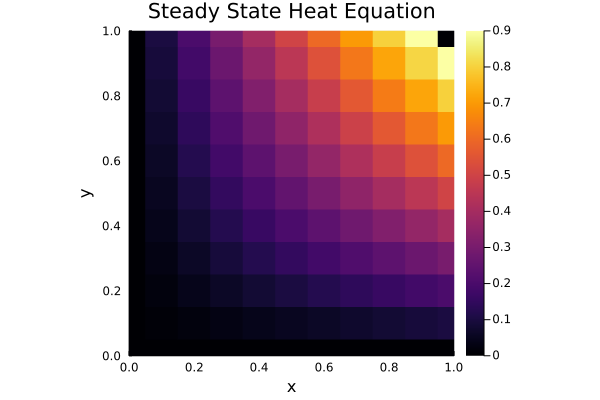

In [5]:
# Get solution on a grid
grid = get_discrete(pdesys, discretization)
u_sol = map(d -> sol[d], grid[u(x, y)])

heatmap(grid[x], grid[y], u_sol, 
        xlabel="x", ylabel="y", aspect_ratio=:equal,
        xlims=(0.0, 1.0), ylims=(0.0, 1.0), 
        title="Steady State Heat Equation")